Data ist from https://data.stadt-zuerich.ch/dataset/vbz-fahrzeiten-ogd . I used `head -n 1000000 fahrzeitensollist2017070220170708.csv > small.csv` to make a subset since I will do a lot of matrix multiplications which is slow.

We try different models to predict waiting time for a specific station (Goldbrunnenplatz) and line (tram 9) when time of day is given.

Since we are doing prediction rather than classical statistics, I decided to work with the package `scikit-learn` and not with `statsmodels`, even if `statsmodels` may be better for regressions.

This example was inspired by chapter 15 from the book Think Bayes from Allen Downey.

In [1]:
%matplotlib inline
import numpy

from datetime import datetime, timedelta
from collections import defaultdict

import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

# Make plots reproducible
numpy.random.seed(0)

# Not necessary, but I like the ggplot style better
plt.style.use('ggplot') 

# Read csv to dataframe
df = pd.read_csv('small.csv')
df_hpunkt = pd.read_csv('haltepunkt.csv')
df_hstelle = pd.read_csv('haltestelle.csv')

Let's get the row of the station and line.

In [2]:
halt_id = df_hstelle[df_hstelle['halt_lang'] == 'Zürich, Goldbrunnenplatz']['halt_id'].item()
linie = 9
selection = df[(df['halt_id_von'] == halt_id) & (df['linie'] == linie)]
print("Found %d records." % (len(selection)))
display(selection.head(3))

Found 1364 records.


,linie,richtung,betriebsdatum,fahrzeug,kurs,seq_von,halt_diva_von,halt_punkt_diva_von,halt_kurz_von1,datum_von,...,fahrweg_id,fw_no,fw_typ,fw_kurz,fw_lang,umlauf_von,halt_id_von,halt_id_nach,halt_punkt_id_von,halt_punkt_id_nach
25910,9,2,02.07.17,3045,9,4,1012,1,GOLP,02.07.17,...,50260,2,1,2,HEUR - HIRZ,137963,701,2060,1558,13552
25924,9,1,02.07.17,2087,6,30,1012,0,GOLP,02.07.17,...,50259,1,1,1,HIRZ - HEUR,135413,701,2627,11584,11393
25978,9,1,02.07.17,3054,7,30,1012,0,GOLP,02.07.17,...,50259,1,1,1,HIRZ - HEUR,136401,701,2627,11584,11393




Let's start with what I have been looking forward to:
$$P(H|D) = \frac{P(H) * P(D|H)}{P(D)}$$

## Bayes

I want to know: When I arrive at a certain station, how long do I have to wait for the next tram/bus/train?

We know the gap between arrival times of the transportation means (tram/bus/train) from the data. So we have the distribution of gap times given. Now

Passenger arrivals will be treated as a Poisson process (they are equally likely to arrive at any time). They arrive at an unknown rate λ [passengers per minute]. λ = λ(t) for t = time.



Found 682 records.
Mean: 8.55 Min.
Median: 8.18 Min.


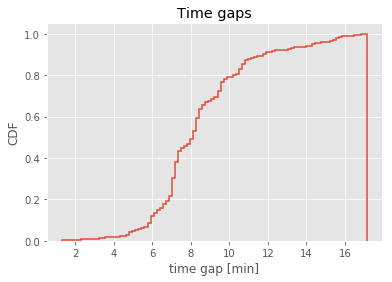

In [3]:
# Copied from above for convenience
halt_id = df_hstelle[df_hstelle['halt_lang'] == 'Zürich, Goldbrunnenplatz']['halt_id'].item()
linie = 9
richtung = 1 # This is new
selection = df[(df['halt_id_von'] == halt_id) & (df['linie'] == linie) & (df['richtung'] == richtung)]

# Makes an datetime object from date string for correct sorting
#df['betriebsdatum'] = df['betriebsdatum'].apply(lambda x: datetime.strptime(x, '%d.%m.%y'))
# Consider: Sorting by betriebsdatum sorts by string, not by date. For correct sorting use the slow 'apply' method above
grouped = selection.sort_values(['betriebsdatum', 'ist_an_von']).groupby(['betriebsdatum'])
print("Found %d records." % (len(selection)))


gaps_over_time = defaultdict(list)
for date, group in grouped:
    ist_before = False
    for index, row in group.iterrows():
        if ist_before is False:
            ist_before = row['ist_an_von']
            continue
            
        gap = row['ist_an_von'] - ist_before
        secs = row['ist_an_von'] # Todo: correct values <0 and >= 86400 ?
       
        gaps_over_time[secs].append(gap)
        ist_before = row['ist_an_von']

times = []
gap_avgs = []
all_gaps = []
for time in sorted(gaps_over_time):
    times.append(time)
    gaps = gaps_over_time[time]
    gap_avgs.append(numpy.mean(gaps))
    all_gaps += gaps

# Remove outliers (it's for nice plots, it doesn't change the results that much)
max_out = 1200 # seconds
all_gaps = numpy.array(all_gaps)
all_gaps = all_gaps[all_gaps < max_out]
gap_avgs = numpy.array(gap_avgs)
times = numpy.array(times)
times = times[gap_avgs < max_out]
gap_avgs = gap_avgs[gap_avgs < max_out]

    
print("Mean: %.2f Min." % (numpy.mean(all_gaps)/60))
print("Median: %.2f Min." % (numpy.median(all_gaps)/60))

# Change to minutes for convenience
toMin = numpy.vectorize(lambda x: float(x)/60)
gaps_mins = toMin(gap_avgs)

plt.title('Time gaps')
plt.xlabel('time gap [min]')
plt.ylabel('CDF')
# Small trick here by using plt.hist instead of doing it for ourself
n, bins, patches = plt.hist(gaps_mins, bins=100, normed=1, histtype='step', cumulative=True, linewidth=1.5)

plt.show()

**Correction for observation bias**

The observer, the passenger, is more likely to arrive in a longer time gap than in a short one. For him the CDF looks different. It is t times more likely to arrive in a time inteval of length t than in a time interval of length 1.

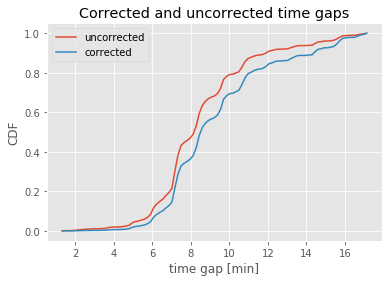

In [4]:
# Compute corrected pmf
n_cor_pmf = [] # Possibility for bin i from bins[1:]
n2 = numpy.concatenate(([0], n)) # n is CDF from uncorrected dist
n_pmf = []
for i, t in enumerate(bins[1:]):
    n_pmf.append(n2[i+1] - n2[i])
    n_cor_pmf.append(t * (n2[i+1] - n2[i]))

# Normalize
n_cor_pmf /= numpy.sum(n_cor_pmf, axis=0)
# Calculate CDF
n_cor = [0]
for val in n_cor_pmf: n_cor.append(n_cor[-1] + val)

plt.plot(bins, n2, label='uncorrected')
plt.plot(bins, n_cor, label='corrected')

plt.title('Corrected and uncorrected time gaps')
plt.xlabel('time gap [min]')
plt.ylabel('CDF')

plt.legend()
plt.show()

* Passenger arrives any time equaly likely
* How long does he have to wait?


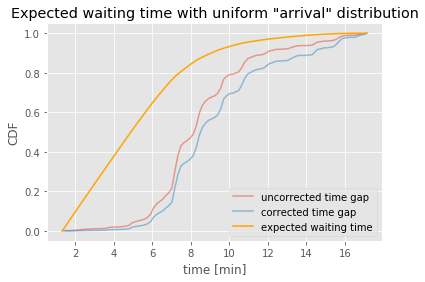

In [5]:
# Make "mixed distribution":
# Waiting time is uniform over interval in which the passenger arrives
# The longer the gap, the more possible it is to arrive in it
n_waiting_pmf = numpy.full(len(bins[1:]), 0.)
# t = probability to hit certain time gap
for i, t in enumerate(n_cor_pmf):
    # probability of arrival for a time interval in time gap
    prob_arrival = 1./(i+1) 
    
    for j in range(0, i):
        # add up possibilities for time intervals for this time gap
        n_waiting_pmf[j] += prob_arrival * t # ~ prior * likelihood

# Normalize
n_waiting_pmf /= numpy.sum(n_waiting_pmf, axis=0)

# Calculate CDF
n_waiting = [0]
for val in n_waiting_pmf: n_waiting.append(n_waiting[-1] + val)
    
# TODO: x is 1.5 to the right, don't know why
plt.plot(bins[1:], n, label='uncorrected time gap', alpha=0.5)
plt.plot(bins, n_cor, label='corrected time gap', alpha=0.5)
plt.plot(bins, n_waiting, label='expected waiting time', color='orange')

#plt.plot(bins[1:], n_pmf, label='uncorrected time gap')
#plt.plot(bins[1:], n_cor_pmf, label='corrected time gap')
#plt.plot(bins[1:], n_elapsed_pmf, label='elapsed time')
#plt.plot(bins[1:], n_waiting_pmf, label='expected waiting time', color='orange')

plt.title('Expected waiting time with uniform "arrival" distribution')
plt.xlabel('time [min]')
plt.ylabel('CDF')

plt.legend()
plt.show()

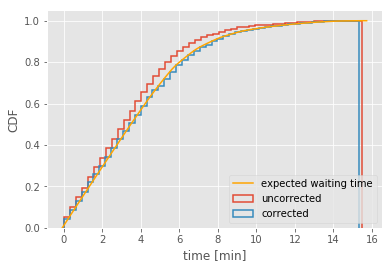

In [6]:
# Just for fun, let's do some sampling
# This is how the "expected waiting time" distribution should look like (above)
import random
n_cor = numpy.array(n_cor)

samples = []
samples_uncor = []
for i in range(0, 10000):
    # Corrected samples
    # Time gap
    z = random.uniform(0, 1)
    i = len(n_cor[n_cor<=z]) # get index of last element<=z
    gap = bins[i]
    # Time passenger arrives
    t = random.choice(bins[0:i+1]) # t is uniform on the time till bin[i+1]

    samples.append(gap - t)
    
    # Again for the uncorrected samples
    i = len(n[n<=z]) 
    gap = bins[i]
    t = random.choice(bins[0:i+1]) 
    samples_uncor.append(gap - t)

plt.hist(samples_uncor, bins=50, normed=1, histtype='step', cumulative=True, linewidth=1.5, label='uncorrected')
plt.hist(samples, bins=50, normed=1, histtype='step', cumulative=True, linewidth=1.5, label='corrected')
# TODO: bins too much to the right, else ok
plt.plot(bins - 1.4, n_waiting, label='expected waiting time', color='orange')

plt.xlabel('time [min]')
plt.ylabel('CDF')

plt.legend(loc='lower right')
plt.show()

The derived distribution (<span style="color:orange">orange</span> line) and samples (here especially the <span style="color:blue">blue</span> line) should be the same.

Now suppose we see k people waiting when we arrive at the station. People arrive with Poisson(k, λ) / min. We exchange the prior ("prob_arrival") from above so that it isn't uniform anymore; it's now going to be poisson distributed.

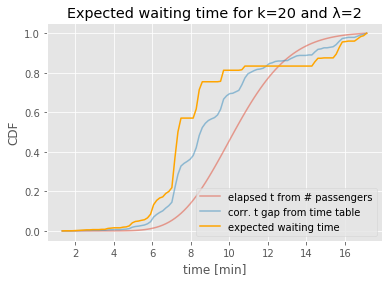

In [7]:
# Given data
# Passengers per minute
lam = 2
# Counted passengers when arriving at station
k = 20

from scipy.stats import poisson

n_elapsed_pmf = numpy.full(len(bins[1:]), 0.)
for i, t in enumerate(bins[1:]):
    n_elapsed_pmf[i] = poisson.pmf(k, lam * t) # that's directly from the formula

# Normalize    
n_elapsed_pmf /= numpy.sum(n_elapsed_pmf, axis=0)

# Calculate expected waiting time
n_waiting_pmf2 = n_cor_pmf - n_elapsed_pmf

# Remove negatives since impossible
n_waiting_pmf2[n_waiting_pmf2 < 0] = 0

# Normalize
n_waiting_pmf2 /= numpy.sum(n_waiting_pmf2, axis=0)

# Calculate CDF
n_waiting = [0]
for val in n_waiting_pmf2: n_waiting.append(n_waiting[-1] + val)
n_elapsed = [0]
for val in n_elapsed_pmf: n_elapsed.append(n_elapsed[-1] + val)
    
plt.plot(bins, n_elapsed, label='elapsed t from # passengers', alpha=0.5)
plt.plot(bins, n_cor, label='corr. t gap from time table', alpha=0.5)
plt.plot(bins, n_waiting, label='expected waiting time', color='orange')

plt.title('Expected waiting time for k=%d and λ=%d' % (k, lam))
plt.xlabel('time [min]')
plt.ylabel('CDF')

plt.legend()
plt.show()

**Explanation**
1. We derived the time gaps between public transports how an observer will encounter them from given data (<span style="color:blue">blue</span> line).
2. We arrive at the station, count _k_ passengers and know that on average _λ_ passengers / minute arrive. From that we get the distribution of passengers over time and time elapsed, when _k_ and _λ_ are given (<span style="color:red">red</span> line).
3. We calculate: corrected time gap - elapsed time = expected time to wait after arriving (<span style="color:orange">orange</span> line).

Can we estimate the arrival rate of passengers _λ_ (=hypotheses)?

In [8]:
# Waiting time, passengers arriving while waiting
observations = ['4,8', '2,1', '3,8']

# Prepare data
w_time = []; pass_arr = []
for o in observations:
    temp = o.split(',')
    w_time.append(temp[0])
    pass_arr.append(temp[1])
    
